> # Part 4 Dynamic Hedging Errors

In [5]:
from scipy.stats import norm
import numpy as np
import matplotlib.pylab as plt
import warnings
import pandas as pd
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
# Ignore all warnings
warnings.filterwarnings("ignore")
from PIL import Image

Black-Scholes introduced the notion of dynamic delta hedging - by executing delta hedges instantaneously, we ensure that our portfolio is delta neutral, and consequently hedged the exposure of our call position using the underlying stock and the risk-free bond. 

The hedged portfolio is $V_t=\phi_tS_t+\psi_tB_t$, where 
\begin{equation*}
\phi_t=\Delta_t=\frac{\partial C}{\partial S}=\Phi\left(\frac{\log\frac{S}{K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

and

\begin{equation*}
\psi_tB_t=-Ke^{-rT}\Phi\left(\frac{\log\frac{S}{K}+\left(r-\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

Let us start by defining these stock and bond holding functions:

In [6]:
def phi(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)


def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -K*np.exp(-r*T)*norm.cdf(d2)

def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)
# Black-Scholes Model
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [7]:
def err_histogram(err_results, N):
    plt.hist(err_results,weights = np.ones(len(err_results))/len(err_results),
             bins = np.linspace(-2,2,40))
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title(f'Hedging Error for N = {N}')
    plt.xlabel('Hedging Error')
    plt.ylabel('Frequency')
    plt.yticks(np.arange(0,0.3,0.05))
    plt.savefig(f'Hedging Error for N = {N}.png')
    plt.show()
    return

## Defining on parameters

In [8]:
paths_p4 = 50000
N1 = 21
N2 = 84
T_p4 = 1/12
r_p4 = 0.05
sigma_p4 = 0.2
S0_p4 = 100
K_p4 = 100

## Viewing on Single Path result
1. Hedging error consist of stockhedge_errors and bondhedge_errors
2. Dynamic Hedging error is a sum of all Hedging errors at differenct steps.

In [9]:
def Hedging_err_plot(steps, maturity, r, S0, K, sigma):
    paths = 1    
    T, W_T = simulate_Brownian_Motion(paths, steps, maturity)

    dt = maturity / steps
    blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0])    

    deltas = []
    stockhedge_errors = []
    bondhedge_errors = []
    hedged_portfolios = []
    stock_holdings = []
    bond_holdings = []
    

    for t, S_t in zip(T, blackscholespath):
        stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
        bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
        V_t = stock_pos + bond_pos

        stock_holdings.append(stock_pos)
        bond_holdings.append(bond_pos)
        hedged_portfolios.append(V_t)
        deltas.append(phi(S_t, K, r, sigma, maturity-t))
        if t == 0.0:
            stockhedge_errors.append(0)
            bondhedge_errors.append(0)
        else:
            stockhedge_errors.append(prev_phi*S_t - stock_pos)
            bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)

        prev_phi = phi(S_t, K, r, sigma, maturity-t)
        prev_bond_pos = bond_pos

    plt.figure(tight_layout=True, figsize=(10, 10))
    plt.subplot(321)
    plt.plot(T, blackscholespath)
    plt.title('Stock price process')
    plt.subplot(322)
    plt.plot(T, deltas)
    plt.title('Delta')
    plt.subplot(323)
    plt.plot(T, stock_holdings)
    plt.title('Stock holding')
    plt.subplot(324)
    plt.plot(T, bond_holdings)
    plt.title('Bond holding')
    plt.subplot(325)
    plt.plot(T, hedged_portfolios)
    plt.title('Hedged portfolio')
    plt.subplot(326)
    plt.plot(T, stockhedge_errors, label='Stock Hedge Err')
    plt.plot(T, bondhedge_errors, label='Bond Hedge Err')
    plt.legend()
    plt.title('Hedging error')
    plt.show()        
    err = sum(stockhedge_errors+bondhedge_errors)

    return err

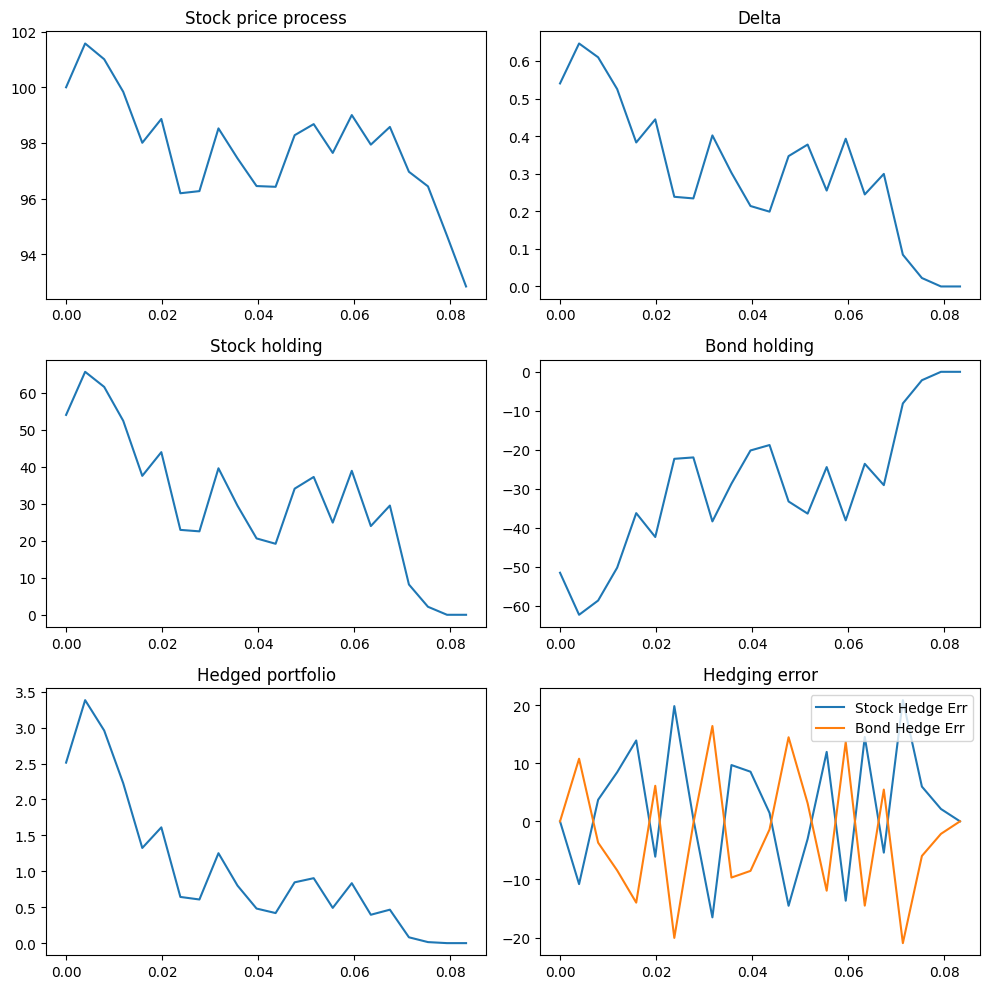

The hedging error for singlepath simulation at 21 steps is accumulated to -0.227.


In [10]:
H_test = Hedging_err_plot(N1, T_p4, r_p4, S0_p4, K_p4, sigma_p4)
print(f'The hedging error for single\
path simulation at {N1} steps is accumulated to {H_test:.3f}.')

## Simulation by 21 hedges with 50000 paths

In [11]:
def Hedging_err_paths(steps, maturity, r, S0, K, sigma, paths):
    err = []
    for i in range(paths):   
        T, W_T = simulate_Brownian_Motion(1, steps, maturity)

        dt = maturity / steps
        blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0])    

        deltas = []
        stockhedge_errors = []
        bondhedge_errors = []
        hedged_portfolios = []
        stock_holdings = []
        bond_holdings = []


        for t, S_t in zip(T, blackscholespath):
            stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
            bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
            V_t = stock_pos + bond_pos

            stock_holdings.append(stock_pos)
            bond_holdings.append(bond_pos)
            hedged_portfolios.append(V_t)
            deltas.append(phi(S_t, K, r, sigma, maturity-t))
            if t == 0.0:
                stockhedge_errors.append(0)
                bondhedge_errors.append(0)
            else:
                stockhedge_errors.append(prev_phi*S_t - stock_pos)
                bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)

            prev_phi = phi(S_t, K, r, sigma, maturity-t)
            prev_bond_pos = bond_pos
      
        err += [sum(stockhedge_errors+bondhedge_errors)]
    return err

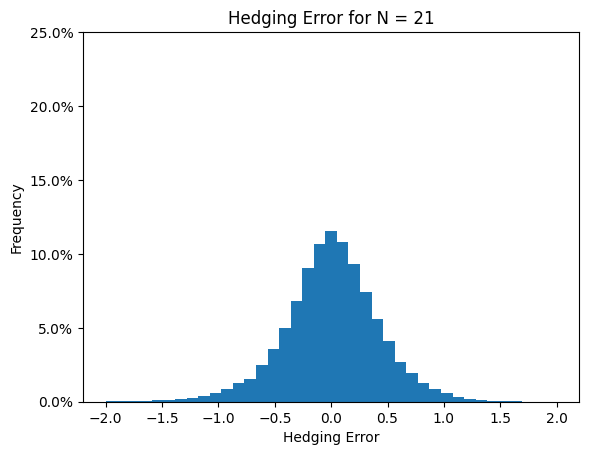

In [12]:
H_result1 = Hedging_err_paths(N1, T_p4, r_p4, S0_p4, K_p4, sigma_p4, paths_p4)
err_histogram(H_result1, N1)

In [18]:
Hedging_21_df = pd.DataFrame({'N = 21 errors': H_result1})
Hedging_21_df.to_csv('Hedging 21 errors.csv')
Hedging_21_df

,N = 21 errors
0,0.349101
1,-0.349336
2,1.002443
3,0.120541
4,-0.461316
...,...
49995,0.156243
49996,0.468082
49997,-0.549888
49998,-0.551587


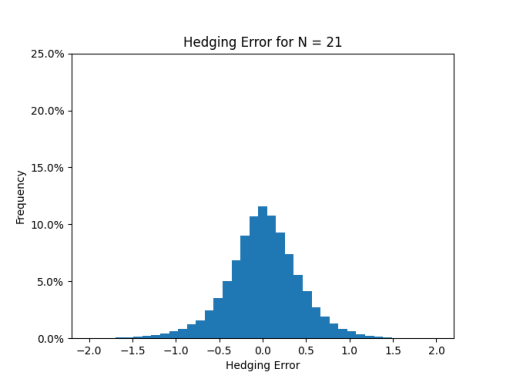

In [19]:
image1 = Image.open("Hedging Error for N = 21.png")

# Display the image using Matplotlib
plt.imshow(image1)
plt.axis('off')  # Turn off the axis if you don't want to display it

# Show the image
plt.show()

## Simulation by 84 hedges with 50000 paths

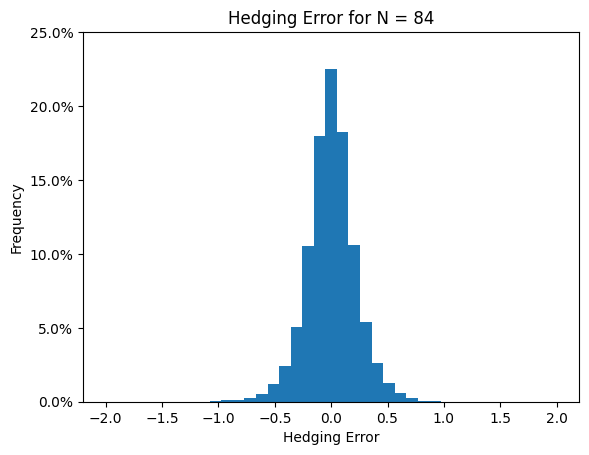

In [20]:
H_result2 = Hedging_err_paths(N2, T_p4, r_p4, S0_p4, K_p4, sigma_p4, paths_p4)
err_histogram(H_result2, N2)

In [21]:
Hedging_84_df = pd.DataFrame({'N = 84 errors': H_result2})
Hedging_84_df.to_csv('Hedging 84 errors.csv')
Hedging_84_df

,N = 84 errors
0,-0.088258
1,-0.127667
2,0.025664
3,-0.023241
4,0.141874
...,...
49995,0.074689
49996,-0.445770
49997,0.496485
49998,0.285935


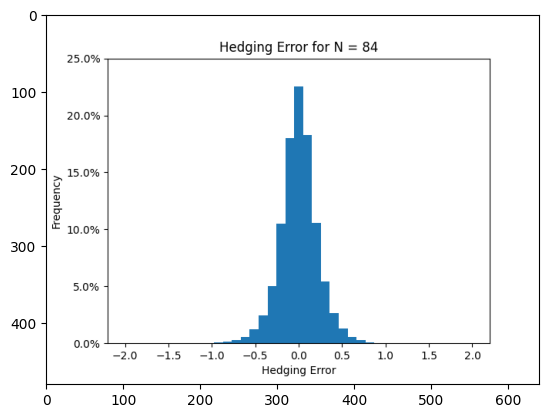

In [22]:
image2 = Image.open("Hedging Error for N = 84.png")

# Display the image using Matplotlib
plt.imshow(image2)
plt.axis('on')  # Turn off the axis if you don't want to display it

# Show the image
plt.show()

## Part 4 Summary

In [23]:
call_price = BlackScholesCall(S0_p4, K_p4, r_p4, sigma_p4, T_p4)
call_price

2.5120670860398846

In [24]:
P4_summary =\
    pd.DataFrame({'Mean P&L': [np.mean(H_result1),
                               np.mean(H_result2)],
                 'Standard Dev. of P&L': [np.std(H_result1),
                               np.std(H_result2)],
                 'Number of trades': [N1, N2]})


P4_summary.set_index('Number of trades', inplace = True)
P4_summary['StDev of P&L as a % of option premium'] =\
    P4_summary['Standard Dev. of P&L'] / call_price * 100
P4_summary.to_csv("P4_summary.csv")
P4_summary

,Mean P&L,Standard Dev. of P&L,StDev of P&L as a % of option premium
Number of trades,,,
21,0.004117,0.423816,16.871198
84,0.001180,0.217767,8.668840
